In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52177 entries, 0 to 52176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eiaid         52177 non-null  int64  
 1   utility_name  52177 non-null  int32  
 2   state         52177 non-null  int32  
 3   service_type  52177 non-null  int32  
 4   ownership     52177 non-null  int32  
 5   comm_rate     52177 non-null  float64
 6   ind_rate      52177 non-null  float64
 7   res_rate      52177 non-null  float64
dtypes: float64(3), int32(4), int64(1)
memory usage: 2.4 MB
Epoch 1/50


C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


147/147 [==============================] - 1s 2ms/step - loss: 0.0718 - val_loss: 0.0453
Epoch 2/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0220
Epoch 3/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 0.0116
Epoch 4/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 5/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 6/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 7/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/50
147/147 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/50
147/147 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/5

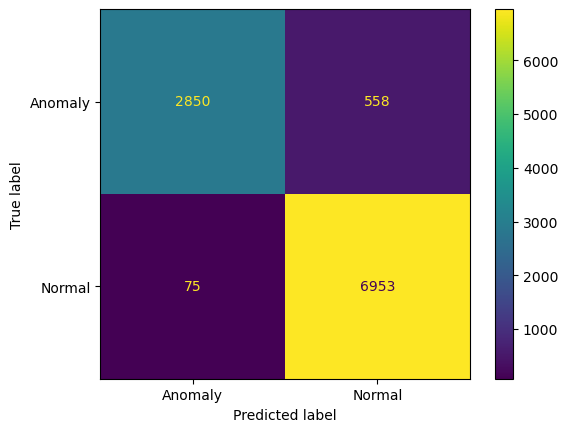

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def hybrid_anomaly_detection():
    # Load data from a CSV file
    #load dataset
    data = pd.read_csv('US_Util_2020.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
#     text_columns = data[['service_type','ownership','state']]
   

#     # Assuming 'text_columns' is a list of columns containing text values
#     label_encoder = LabelEncoder()
#     for col in text_columns:
#         data[col + '_encoded'] = label_encoder.fit_transform(data[col])
        
#     label_encoder = LabelEncoder()
#     data['state_encoded'] = label_encoder.fit_transform(data['state'])
#     data['service_type_encoded'] = label_encoder.fit_transform(data['service_type'])
#     data['ownership_encoded'] = label_encoder.fit_transform(data['ownership'])
    
    
    data = data.drop(['zip'], axis=1)
    
    
    data.info()
    X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['res_rate']
    
    data = data.dropna(axis=0, inplace=True)
#     #convert all the values in the columns into numeric
#     for column in data.columns:
#         data[column] = pd.to_numeric(data[column], errors='coerce')

    y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
    
    selector = SelectKBest(f_classif, k=6)
    X_selected = selector.fit_transform(X, y)
    
    X_selected

    
    
    
    
    

    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Define and train the autoencoder
    input_dim = X_train.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_encoded)
    if_train_labels = iso_forest.predict(X_train_encoded)
    
    # Filter only rows detected as normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_encoded[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_normal, y_train_normal)
    
    # Predict on the entire test dataset
    svm_predictions = svm.predict(X_test_encoded)
    
    # Evaluate the model
    precision = precision_score(y_test, svm_predictions, pos_label=1)
    recall = recall_score(y_test, svm_predictions, pos_label=1)
    f1 = f1_score(y_test, svm_predictions, pos_label=1)
    
    
    print(classification_report(y_test, svm_predictions))

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage, assuming the CSV file is correctly formatted and located
hybrid_anomaly_detection()
